# Approximation of a probability distribution of leak rates

This tries to take published measurements of leak rates and combine them into a common probability distribution.

https://doi.org/10.1016/j.oneear.2022.05.012 already contains such a distribution, we try to add the values we found by correcting for sample size.

## Setup

In [13]:
# You might have to install some or all of the following.
# We worked on a fresh python 3.11 conda environment, but most python 3 should work.

if False:
    %pip install pandas matplotlib numpy openpyxl plotly plotly-orca
    # or %conda install -c

In [14]:
import pandas as pd
import numpy as np
import scipy.stats as st
import openpyxl
import kaleido  # for image saving
import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle
import random

# Those two are needed to add the static image to a graph legend
import plotly.io as pio
from PIL import Image

%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


## Define parameters

Please adapt to your setup

In [15]:
SAVEDIR = "images/"
LOADDIR = "data/"

import os

if not os.path.isdir(SAVEDIR):
    os.mkdir(SAVEDIR)

In [16]:
# contains name mappings and RED II default values for all relevant plant parts
plant_parts = pd.read_csv(LOADDIR + "plant_parts.csv")

#
# Methane mass to percentage conversion
#
energy_density_methane = (
    55.5  # MJ/kg, HHV. Used to convert absolute leak rates to production shares
)
GWP_methane = 25  # to be aligned with RED II. Could be replaced with IPCC AR6.


def convert_perc_to_abs(value):
    # % / MJ/(kg CH4) * g/kg / % * (g CO2eq/g CH4) = g CO2eq / MJ CH4
    return value / energy_density_methane * 1000 / 100 * GWP_methane


def convert_abs_to_perc(value):
    return value * energy_density_methane / 1000 * 100 / GWP_methane

## Load data from literature review

The data is in the Excel file "Legislation and paper data.xlsx"

In [17]:
# load the dataset
df = pd.read_excel(
    LOADDIR + "parameters_and_literature.xlsx",
    "Literature_emissions",
    engine="openpyxl",
)

# we only use the values in the unit of share "methane lost over methane produced"
df = df[df["unit"] == "CH4/CH4_prod"]

# we work in % in this model
# convert ratio to %
df[["Value", "min", "max"]] = df[["Value", "min", "max"]] * 100

# if no number of plants is given, assume 1
df["Number of plants"] = pd.to_numeric(df["Number of plants"], errors="coerce").fillna(
    1
)

## Triangle distributions
We use triangle distributions for all literature sources that measured several plants and gave min and max values. As differences between sources and statistical information given are high, we assume this to be the most robust method.

The distributions are used to re-create a sample of data that can be combined with the values from other literature sources. Each sample size is defined by a static factor ("sample_size") and the number of plants measured.

In [18]:
# mode is `Value`, number is `Number of plants`
def return_triangle_values(min, max, mode, number, sample_size):
    """
    creates a sample of triangle-distributed values
    min: left bound of triangle
    max: right bound of triangle
    mode: highest point of triangle
    number: number of plants, extracted from the Excel file
    sample_size: user defined, higher to have a better fit of the triangle shape

    returns a list of size sample_size * number
    """
    # if no distribution, than only take the one value
    if number == 1 or np.isnan(min) or np.isnan(max):
        return [mode] * sample_size
    # total size is sample_size times number of plants
    size = int(number) * sample_size
    # scipy triangle distribution
    triangle_values = st.triang.rvs(
        loc=min, scale=max - min, c=(mode - min) / (max - min), size=size
    )
    return list(triangle_values)


# Use the Excel values with min-max to create a triangle distribution and draw `sample_size` times the `Number of plants` values for each distribution
# sample size is only needed for two reasons:
# * to create a gaussian_kde (to compare with Bakkaloglu for example)
# * to have smoother curves. The effect is not so big though
def create_samples_from_excel(df, sample_size=10):
    """
    returns a new dataframe containing one line for each sample.
    For each line in the Excel file, sample_size * number of plants samples are generated
    """
    df_samples = df.copy()
    df_samples["samples"] = df.apply(
        lambda x: return_triangle_values(
            min=x["min"],
            max=x["max"],
            mode=x["Value"],
            number=x["Number of plants"],
            sample_size=sample_size,
        ),
        axis=1,
    )
    df_samples = df_samples.explode("samples")
    return df_samples

In [19]:
# create a sample to visualize the collected data and also use later on
sample_size = 100
df_samples = create_samples_from_excel(df=df, sample_size=sample_size)
# only keep relevant columns
df_samples = df_samples[["Authors", "Plant part", "samples"]]
df_samples.set_index("Plant part", inplace=True)

# extract a lookup table from plant_parts to replace the names
excel_plant_parts = (
    plant_parts[["name", "excelname"]].set_index("excelname").to_dict()["name"]
)
# rename to have similar names
df_samples.rename(excel_plant_parts, inplace=True)

### Visualisation of the data

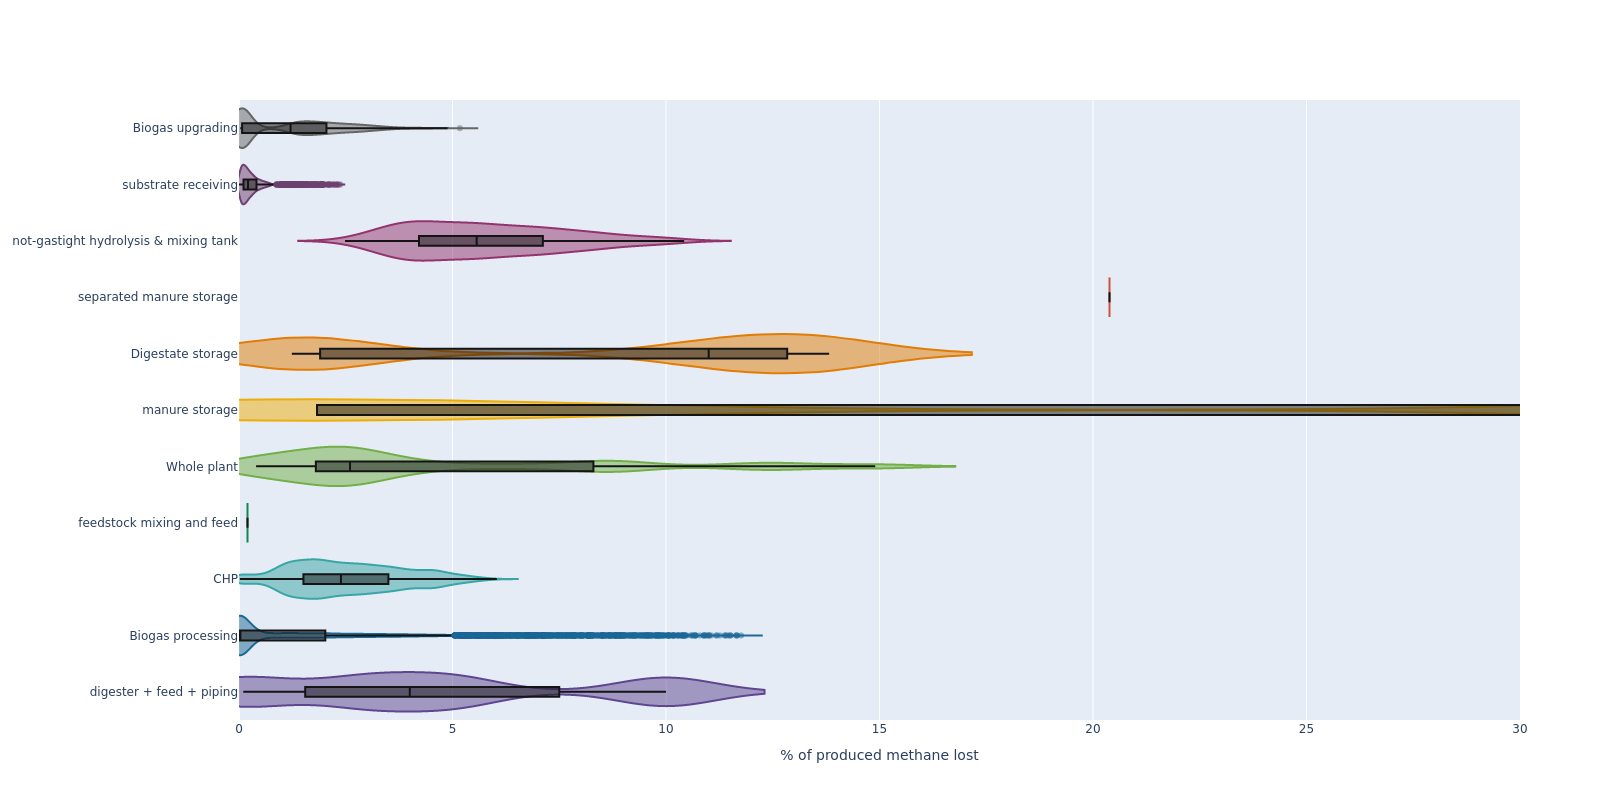

In [20]:
# visualize results as a violinplot
categories = df_samples.index.unique()
fig = go.Figure()
palette = cycle(px.colors.qualitative.Prism)
for category in categories:
    category_values = df_samples.loc[category].samples
    fig.add_trace(
        go.Violin(
            x=category_values,
            name=category,
            box_visible=True,
            marker_color=next(palette),
            marker_opacity=0.5,
        )
    )
# Update all traces (all violins)
fig.update_traces(
    orientation="h",  # Horizontal violin plots
    box_fillcolor="rgba(20,20,20,0.5)",  # Color of the boxplot's fill
    box_line_color="rgb(20,20,20)",  # Color of the boxplot's line
)
fig.update_layout(
    violingap=0,
    height=800,
    width=1600,
    showlegend=False,
    xaxis={"range": [0, 30], "title": "% of produced methane lost"},
)
# Show the figure as png image (to reduce ipynb file size)
# delete 'renderer="png"' to get a nicer looking image
fig.show(renderer="png")

In [21]:
# plot the same data with a gaussian KDE
def get_gaussian_kde(df_samples):
    result = dict()
    parts = df_samples.index.unique()
    for part in parts:
        filtered = df_samples.loc[part]
        if max(filtered.samples) > min(filtered.samples):
            result[part] = st.gaussian_kde(list(filtered.samples))
    return result


kdes = get_gaussian_kde(df_samples)
x_range = np.linspace(0, 18, 100)
kde_sample = dict()
for name, kde in kdes.items():
    kde_sample[name] = kde(x_range)
kde_sample.update(dict(x_range=x_range))
df_gaussian = pd.DataFrame(kde_sample)
df_gaussian.set_index("x_range", inplace=True)
df_gaussian.rename(
    {"x_range": "% of produced biomethane lost", "value": "probability"}, inplace=True
)
fig = px.line(df_gaussian)
fig.update_layout(
    {
        "yaxis": {"title": "probability", "showticklabels": False},
        "xaxis": {"title": "% of produced biomethane lost"},
    }
)

## Add data from Bakkaloglu et al.
### Get the raw data
https://doi.org/10.1016/j.oneear.2022.05.012

The code below is copied from their supplementary material and adapted to our needs.

For the visualisation, we only use the raw data and not the gaussian KDE fits.

In [22]:
# choose the file location
# apply same code to the percentage of production data
INPUT_FILE = "Data_absolute.csv"  # absolute values
INPUT_FILE2 = "Data_relative.csv"  # relative values as percentage


# Load samples from spreadsheet
def load_samples(filename, filename2):
    dict_samples = {}
    df_all = pd.read_csv(filename)
    # Data.csv contains absolute values
    df_all = convert_abs_to_perc(df_all)
    df_all_2 = pd.read_csv(filename2)
    for col in df_all.columns:
        dict_samples[col] = np.append(
            df_all[col].dropna().values, df_all_2[col].dropna().values
        )
    return dict_samples


bakkaloglu_data = load_samples(LOADDIR + INPUT_FILE, LOADDIR + INPUT_FILE2)

# duplicate the data sample_size times to weigh it the same as the collected data
bakkaloglu_dict = {
    col: np.tile(bakkaloglu_data[col], sample_size) for col in bakkaloglu_data
}
df_bakkaloglu = pd.DataFrame(
    pd.concat({k: pd.Series(v) for k, v in bakkaloglu_dict.items()}).droplevel(1),
    columns=["samples"],
)
df_bakkaloglu["Authors"] = "Bakkaloglu et al. 2022"
df_bakkaloglu.index.name = "Plant part"

### Combine Excel and Bakkaloglu

In [23]:
df_combined = pd.concat([df_samples, df_bakkaloglu])

### Visualise results

In [24]:
def plot_leak_distributions(df_to_plot):
    # Sort values to have them in a more logical order
    sorter = list(plant_parts.query("show_combined == True")["name"])
    local_df = df_to_plot.query("index in @sorter").copy()
    local_df.sort_index(
        key=lambda column: column.map(lambda e: sorter.index(e)), inplace=True
    )
    # colors
    palette = cycle(px.colors.qualitative.Prism)
    fig = go.Figure()
    # to only show legend once
    is_first_trace = True
    for pp in local_df.index.unique():

        fig.add_trace(
            go.Violin(
                y=df_to_plot.index[df_to_plot.index == pp],
                x=df_to_plot["samples"][df_to_plot.index == pp],
                orientation="h",
                points=False,  #'all',
                pointpos=0.5,
                box_visible=True,
                box_fillcolor="rgba(20,20,20,0.7)",  # Color of the boxplot's fill
                box_line_color="rgb(20,20,20)",  # Color of the boxplot's line
                width=0.9,
                marker_color=next(palette),
                marker_opacity=0.2,
                opacity=0.9,
                showlegend=False,
            )
        )

        red_vals = plant_parts.query("name == @pp")[["red_min", "red_max"]]
        # red_vals = next(item for item in plant_parts if item["name"] == pp)
        fig.add_trace(
            go.Scatter(
                y=[pp, pp],
                x=[red_vals["red_min"].values[0], red_vals["red_max"].values[0]],
                name="RED II",
                marker_color="red",
                line_color="rgba(255, 0, 0, 0.5)",
                marker_opacity=1,
                showlegend=is_first_trace,
            )
        )
        is_first_trace = False

    fig.update_layout(
        xaxis_range=[0, 25],
        xaxis_title="% of produced methane lost",
        height=600,
        width=800,
        legend=dict(yanchor="top", y=0.1, xanchor="left", x=0.8, itemwidth=70),
    )

    # to render in jupyterlab
    pio.renderers.default = "plotly_mimetype"
    explanation = Image.open("explanation boxplot.png")
    fig.add_layout_image(
        dict(
            source=explanation,
            xanchor="left",
            x=0.796,
            yanchor="top",
            y=0.245,
            sizex=0.25,
            sizey=1,
            sizing="contain",
            layer="below",
        )
    )
    fig.add_shape(
        type="rect",
        xref="paper",
        yref="paper",
        xanchor="left",
        yanchor="top",
        x0=0.796,
        y0=0.245,
        x1=1.05,
        y1=0.027,
        line=dict(
            color="grey",
            width=3,
        ),
        fillcolor="rgba(0,0,0,0)",
    )
    return fig

#### Distribution of all sources together

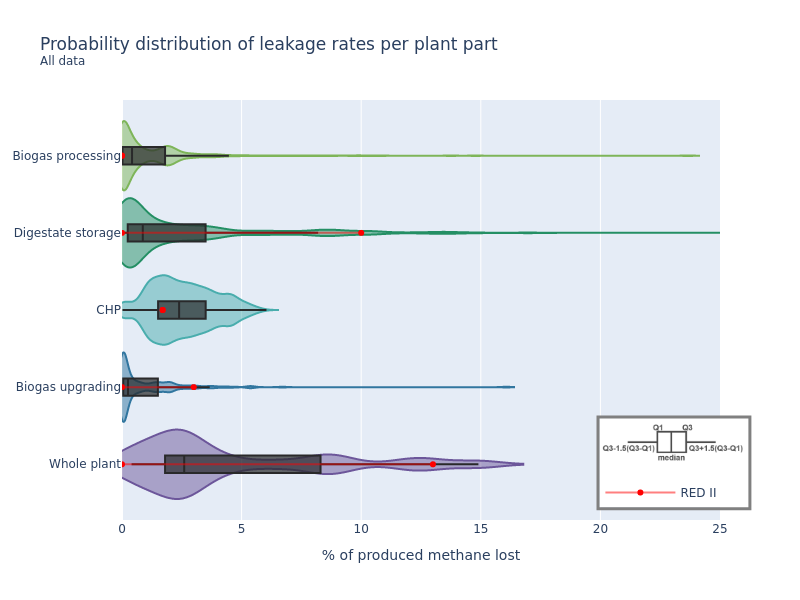

In [25]:
fig = plot_leak_distributions(df_combined)
fig.update_layout(
    title="Probability distribution of leakage rates per plant part<br><sup>All data</sup>"
)
fig.write_image(SAVEDIR + "emissions_violinplot-combined.png", format="png")
fig.show(renderer="png")

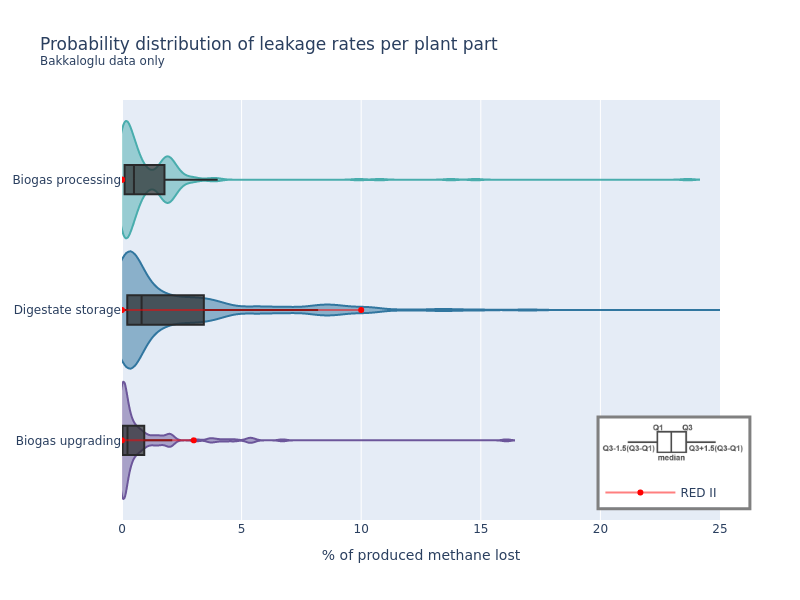

In [26]:
fig = plot_leak_distributions(df_bakkaloglu)
fig.update_layout(
    title="Probability distribution of leakage rates per plant part<br><sup>Bakkaloglu data only</sup>"
)
fig.write_image(SAVEDIR + "emissions_violinplot-bakkaloglu.png", format="png")
fig.show(renderer="png")

#### Comparison of own collected data and Bakkaloglu

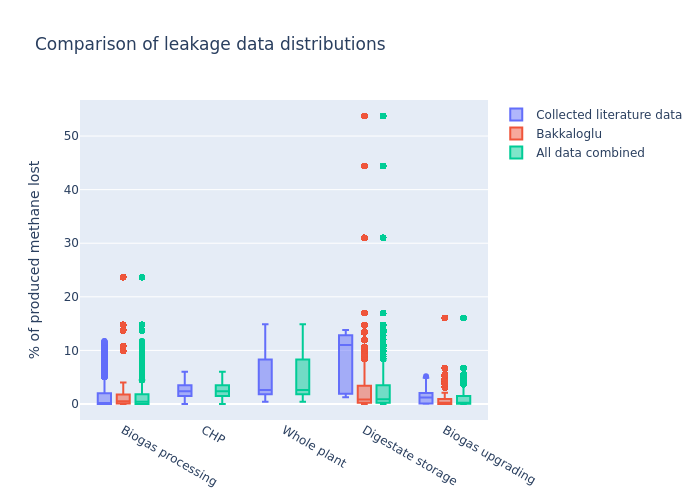

In [27]:
fig = go.Figure()
sorter = list(plant_parts.query("show_combined == True")["name"])
for lit_name, lit_source in zip(
    ["Collected literature data", "Bakkaloglu", "All data combined"],
    [df_samples, df_bakkaloglu, df_combined],
):
    lit_source = lit_source.reset_index().query("`Plant part` in @sorter")
    fig.add_trace(
        go.Box(x=lit_source["Plant part"], y=lit_source["samples"], name=lit_name)
    )
fig.update_layout(
    boxmode="group",
    yaxis_title="% of produced methane lost",
    title="Comparison of leakage data distributions",
)
fig.show(renderer="png")

# Impact on RED II default values

Here we calculate the impact methane leaks have on reaching the RED II GHG reduction threshold by calcuating for selected pathways the impact on overall emissions and GHG reductions compared to the fossil fuel comparator, based on the above methane emission distributions

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy import signal

delta = 1e-1
big_grid = np.arange(0, 20, delta)

distributions = get_gaussian_kde(
    df_combined.loc[["Digestate storage", "Biogas upgrading", "Biogas processing"]]
)

pdfs = {name: distributions[name].pdf(big_grid) for name in distributions}

leak_prob_chp = signal.fftconvolve(
    pdfs["Digestate storage"], pdfs["Biogas processing"], "same"
)
leak_prob_upg = signal.fftconvolve(leak_prob_chp, pdfs["Biogas upgrading"], "same")

big_grid_gCO2eq = convert_perc_to_abs(big_grid)

In [28]:
from plotly.subplots import make_subplots

# set the thresholds
threshold_methane = 94 * 0.35
threshold_electricity = 183 * 0.2

# load the dataset
df_red_typical = pd.read_excel(
    LOADDIR + "parameters_and_literature.xlsx",
    "red_typical",
    engine="openpyxl",
    header=0,
    skiprows=[1],
).set_index(["Feedstock", "Use"])[
    [
        "Cultivation",
        "Processing",
        "Transport & distribution",
        "Further processing",
        "Manure Credits",
    ]
]
df_red_typical = df_red_typical.replace(np.nan, 0.0)
df_red_typical["sum"] = df_red_typical.sum(axis=1)

column_titles = list(
    reversed(df_red_typical.index.get_level_values(1).unique().to_list())
)
row_titles = list(reversed(df_red_typical.index.get_level_values(0).unique().to_list()))

fig = make_subplots(
    rows=3,
    cols=2,
    shared_yaxes=True,
    row_titles=row_titles,
    start_cell="top-left",
    column_titles=column_titles,
)
count_i, count_j = 0, 0
for i, df in df_red_typical.groupby(by="Use"):
    count_i += 1
    count_j = 0
    df.insert(1, "Manure Credits", df.pop("Manure Credits"))
    for j, df_uni in df.groupby(by="Feedstock"):
        count_j += 1
        df_uni.columns.name = "Step"
        data = df_uni.stack()
        data.name = "value"
        data = data.reset_index()
        data = data.replace({"sum": "methane emissions"})
        data["measure"] = data["Step"].apply(
            lambda s: "total" if s == "methane emissions" else "relative"
        )
        fig.add_trace(
            go.Waterfall(
                x=data["Step"],
                y=data["value"],
                measure=data["measure"],
                decreasing={"marker": {"color": "Green"}},
                increasing={"marker": {"color": "Teal"}},
                totals={"marker": {"color": "rgba(0,100,200,0.1)"}},
            ),
            row=count_j,
            col=count_i,
        )

        # Add the probability boxplot
        cur_sum = data.loc[data["Step"] == "methane emissions", "value"].values[0]
        if i == "Biogas for electricity":
            normalized_probability = leak_prob_chp / sum(leak_prob_chp)
            threshold = threshold_electricity
            threshold_text = "RED II threshold (80% reduction FFC electricity)"
        else:
            normalized_probability = leak_prob_upg / sum(leak_prob_upg)
            threshold = threshold_methane
            threshold_text = "RED II threshold (65% reduction FFC transport)"
        fig.add_trace(
            px.box(
                x=["methane emissions"] * 10000,
                y=np.random.choice(big_grid_gCO2eq, 10000, p=normalized_probability)
                + cur_sum,
                points=False,
            ).data[0],
            row=count_j,
            col=count_i,
        )

        # Add the RED II threshold as red line
        xes = data["Step"].unique().tolist()
        red_text = ""
        if count_j == 1:
            red_text = [threshold_text] + ([""] * (len(xes) - 1))
        fig.add_trace(
            go.Scatter(
                x=xes,
                y=[threshold] * len(xes),
                mode="lines+text",
                text=red_text,
                textposition="top right",
                textfont=dict(color="rgba(200,0,0,0.5)", size=16),
                line=dict(color="rgba(200,0,0,0.5)"),
            ),
            row=count_j,
            col=count_i,
        )


fig.for_each_annotation(
    lambda a: (
        a.update(
            x=0.44,
            textangle=0,
            align="center",
            width=100,
            font=dict(size=16.5),
        )
        if a.text in row_titles
        else (
            a.update(
                font=dict(size=20),
            )
        )
    )
)
fig.update_xaxes(showticklabels=False)
fig.update_xaxes(showticklabels=True, row=3, tickangle=-90)
fig.update_yaxes(title="g CO<sub>2</sub>eq/MJ", row=2, col=1)
fig.update_layout(
    height=1000,
    width=1200,
    showlegend=False,
    font=dict(size=17),
)
fig.write_image(SAVEDIR + "red2_impact.png", format="png")
fig.show(renderer="png")

NameError: name 'leak_prob_upg' is not defined

# Biogas plant economics of LDAR programme
The following code creates probability distributions for the leakage rates for the main parts of a biogas plant: biogas production, biogas use and digestate storage. The code to create those probability functions comes from https://doi.org/10.1016/j.oneear.2022.05.012.

It then creates probability distributions for other main parameters: plant size, detection and repair costs, electricity or biomethane revenues.

Based on the distributions, a Monte Carlo simulation calculates the probability distribution of the payback time of a LDAR programme, assuming an increased revenue through increased biogas production.

In [29]:
# Repair costs for each component in each plant part.
# This is the part of the model with the highest uncertainty. We don't know how often a certain component or plant type
# leaks, and if there is a correlation between the component and the leak size. We assume every value we received to have
# the same probability
repair_costs = pd.read_excel(
    LOADDIR + "parameters_and_literature.xlsx", "repair_costs", engine="openpyxl"
)

# Parameters to define the costs and revenues: plant size, biogas and biomethane selling price and detection costs.
economic_parameters = pd.read_excel(
    LOADDIR + "parameters_and_literature.xlsx", "economic_parameters", engine="openpyxl"
)

## Visualisation of the parameters

In [30]:
def get_distribution(df_row):
    if (
        "distribution_type" not in df_row.index
        or df_row["distribution_type"] == "uniform"
    ):
        # uniform distribution starting at min and having a "scale" ov max-min
        dist = st.uniform(df_row["min"], df_row["max"] - df_row["min"])
        return dist
    elif df_row["distribution_type"] == "beta":
        # beta needs the parameters a,b,min and scale
        dist = st.beta(df_row["a"], df_row["b"], df_row["min"], df_row["scale"])
        return dist


def plot_distribution(pdf, df_row):
    min = df_row["min"]
    max = np.nanmax([df_row["max"], df_row["scale"]])
    x = np.linspace(min * 0.9, max * 1.05, 80)
    y = pdf.pdf(x)
    trace = go.Scatter(x=x, y=y, line_color="green")
    fig = go.Figure(
        data=trace,
        layout=dict(
            title=df_row["Parameter"],
            xaxis_title=df_row["Unit"],
            yaxis_title="Probability",
            font=dict(size=28),
        ),
    )
    fig.update_yaxes(showticklabels=False)
    fig.show()


economic_parameters.apply(lambda x: plot_distribution(get_distribution(x), x), axis=1)

0    None
1    None
2    None
3    None
4    None
dtype: object

## Monte carlo simulation of virtual plants
The following creates a number mc_samples of plants that follow the input parameter distributions
You can change the used leak data from combined to df_samples or df_bakkaloglu

In [31]:
def preserve_first_occurence(list_with_duplicates, dup_to_eliminate):
    it = iter(list_with_duplicates)
    for val in it:
        yield val
        if val == dup_to_eliminate:
            yield from (el for el in it if el != dup_to_eliminate)


# change if you only want to take own or Bakkaloglu leak data
leak_data_to_use = df_combined

# change this to change the number of simulated plants
mc_samples = 10000


def define_leaking_components(pp_name, mc_dict, mc_samples):
    # number of leaks for this component
    mc_dict["leak_number_" + pp_name] = np.ceil(
        st.expon.rvs(scale=1, size=mc_samples)
    ).astype(int)
    # For each plant part, create a list of potentially leaking components
    potentially_leaking_components = repair_costs.query("`Plant part` == @pp_name")[
        "Faulty component"
    ].to_list()
    # Same, but only components that can only be repaired once
    potentially_leaking_components_only_once = repair_costs.query(
        "only_one_repair_possible == True and `Plant part` == @pp_name"
    )["Faulty component"].to_list()

    # The whole part selects leak_number random components for each MC sample
    # and eliminates duplicates of components that can be repaired only once
    rand_components = np.array(
        random.choices(potentially_leaking_components, k=mc_samples + 100)
    )  # 100 more to have enough for multiple leaks
    # a bit of numpy selection magic to keep the right number of components corresponding to the number of leaks
    chosen_components = [
        rand_components[i : i + mc_dict["leak_number_" + pp_name][i]]
        for i in range(mc_samples)
    ]
    # components that are marked to only have to be repaired once are filtered out
    chosen_components_filtered = chosen_components
    for only_once_comp in potentially_leaking_components_only_once:
        for chosen_comp in chosen_components_filtered:
            chosen_comp = preserve_first_occurence(chosen_comp, only_once_comp)

    repair_cost_samples = dict()
    for component in potentially_leaking_components:
        # in absence of better info, use a uniform distribution of the repair cost, generate enough samples
        this_component = repair_costs.query(
            "`Plant part` == @pp_name and `Faulty component` == @component"
        )
        min_costs = this_component["min"]
        max_costs = this_component["max"]
        repair_cost_samples[component] = st.uniform.rvs(
            min_costs, max_costs - min_costs, mc_samples
        )
    # sum up the repair costs for all leaking components for each experience
    mc_dict["repair_cost_" + pp_name] = np.array(
        [
            sum(repair_cost_samples[comp][i] for comp in chosen_components_filtered[i])
            for i in range(mc_samples)
        ]
    )


def define_leak_rates(pp_name, mc_dict, mc_samples, fit_kdes):
    # create leakage rates for each component, based on fit_kde
    rate = fit_kdes[pp_name].resample(mc_samples)[0]
    # this removes negative emissions (due to a fitted probability distribution). We keep zeroes to avoid systematic leakages at every plant part
    mc_dict["leak_rates_" + pp_name] = np.where(rate >= 0, rate, 0)
    mc_dict["leak_number_" + pp_name] = np.where(
        rate >= 0, mc_dict["leak_number_" + pp_name], 0
    )


def create_plant_part_mc(pp_name, mc_dict, mc_samples, fit_kdes):
    define_leaking_components(pp_name, mc_dict, mc_samples)
    define_leak_rates(pp_name, mc_dict, mc_samples, fit_kdes)

    # we create a distribution for each economic parameter and create a sample size
    # contains biogas and biomethane prices, detection costs and plant size
    economic_parameters_samples = (
        economic_parameters.set_index("Parameter")
        .apply(lambda x: get_distribution(x).rvs(mc_samples), axis=1)
        .to_dict()
    )
    mc_dict.update(economic_parameters_samples)


def yearly_increased_revenue_chp(
    row: pd.DataFrame,  # a row of the dataframe created above
    chp_efficiency: float = 0.325,  # conversion efficiency from biogas energy to electricity
) -> pd.DataFrame:  # a new column with revenue
    """returns yearly revenue increase of campaign in EUR for a CHP plant"""
    return (
        row["leak_rate_chp"]
        / 100
        * chp_efficiency
        * row["biogas plant size"]
        * 1000
        * row["biogas price"]
        / 100
    )


def yearly_increased_revenue_upg(
    row,  # a row of the dataframe created above
) -> pd.DataFrame:  # a new column with revenue
    """returns yearly revenue increase of campaign in EUR for an upgrading plant"""
    return (
        row["leak_rate_upg"]
        / 100
        * row["biomethane plant size"]
        * 1000
        * row["biomethane price"]
        / 100
    )


def net_present_value(revenues: float, interest_rate: float, year):
    return revenues / ((1 + interest_rate) ** year)


def discounted_payback(invest: float, yearly_revenues: float, interest_rate: float):
    payback_years = 0
    npv = invest
    while npv > net_present_value(
        revenues=yearly_revenues, interest_rate=interest_rate, year=payback_years
    ):
        npv = npv - net_present_value(
            revenues=yearly_revenues, interest_rate=interest_rate, year=payback_years
        )
        payback_years += 1
        if payback_years > 50:
            return payback_years
    payback_years += npv / net_present_value(
        revenues=yearly_revenues, interest_rate=interest_rate, year=payback_years + 1
    )
    return payback_years


def create_n_plants(
    leak_data_to_use, mc_samples: int  # the number of samples to create
) -> (
    pd.DataFrame
):  # a dataframe containing mc_samples rows with plant size, leakage rates and detection and repair costs
    """creates plants from probability distributions"""
    mc_dict = {}

    # prepare the leak data by filtering
    selected_plant_parts = plant_parts.query("use_for_economics")["name"]
    leak_data_to_use = leak_data_to_use.query("`Plant part` in @selected_plant_parts")
    leak_data_kdes = {
        grouped_leak_data[0]: st.gaussian_kde(
            list(grouped_leak_data[1]["samples"].values)
        )
        for grouped_leak_data in leak_data_to_use.groupby("Plant part")
    }

    # plant parts. We only use "Biogas processing", "Biogas upgrading" and "Digestate storage"
    for pp_name in selected_plant_parts:
        create_plant_part_mc(pp_name, mc_dict, mc_samples, leak_data_kdes)

    # we put everything in a dataframe
    df = pd.DataFrame(mc_dict)
    # for easy access, create totals for leak rates and repair costs
    df["repair_cost_upg"] = sum(
        mc_dict["repair_cost_" + pp] for pp in selected_plant_parts
    )
    df["repair_cost_chp"] = sum(
        mc_dict["repair_cost_" + pp]
        for pp in selected_plant_parts
        if pp != "Biogas upgrading"
    )

    df["total_cost_upg"] = df["detection costs"] + df["repair_cost_upg"]
    df["total_cost_chp"] = df["detection costs"] + df["repair_cost_chp"]

    df["leak_rate_upg"] = sum(
        mc_dict["leak_rates_" + pp] for pp in selected_plant_parts
    )
    df["leak_rate_chp"] = sum(
        mc_dict["leak_rates_" + pp]
        for pp in selected_plant_parts
        if pp != "Biogas upgrading"
    )  # + data['chp_slip_rate'] not included as considered not fixeable
    # Delete all plants where the leak rate in case of CHP is 0 (to exclude infinite payback times). This creates a slight overrepresentation of higher leakages for upgrading plants.
    df = df[df["leak_rate_chp"] > 0]
    # Delete all unrealistically high leaks
    df = df[df["leak_rate_upg"] < 30]

    # Calculate increased revenue and payback
    df["increased_revenue_chp"] = df.apply(yearly_increased_revenue_chp, axis=1)
    df["increased_revenue_upg"] = df.apply(yearly_increased_revenue_upg, axis=1)

    df["payback_chp"] = df["total_cost_chp"] / df["increased_revenue_chp"]
    df["payback_upg"] = df["total_cost_upg"] / df["increased_revenue_upg"]

    df["discounted_payback_chp"] = df.apply(
        lambda row: discounted_payback(
            invest=row["total_cost_chp"],
            yearly_revenues=row["increased_revenue_chp"],
            interest_rate=0.05,
        ),
        axis=1,
    )
    df["discounted_payback_upg"] = df.apply(
        lambda row: discounted_payback(
            invest=row["total_cost_upg"],
            yearly_revenues=row["increased_revenue_upg"],
            interest_rate=0.05,
        ),
        axis=1,
    )

    return df


df = create_n_plants(leak_data_to_use, mc_samples)

## Visualisation of the created plant parameters (histograms)

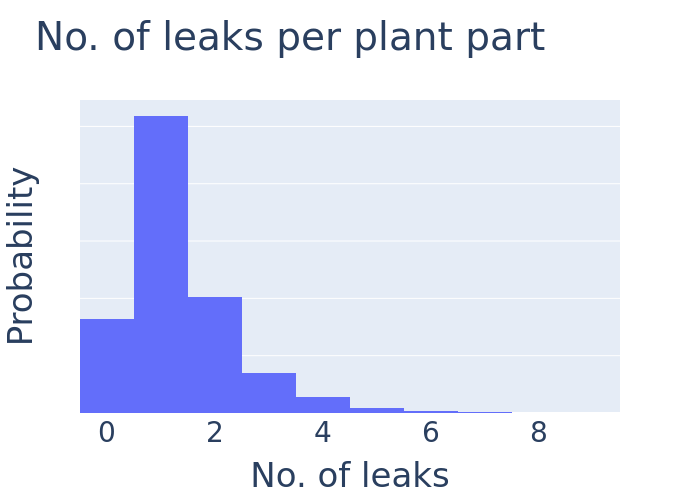

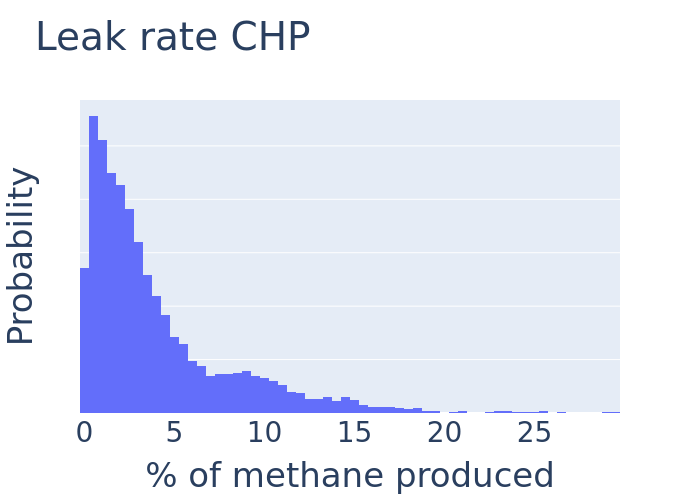

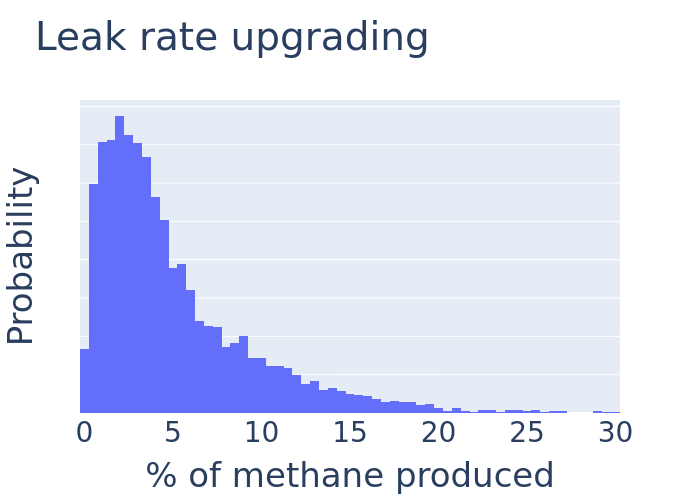

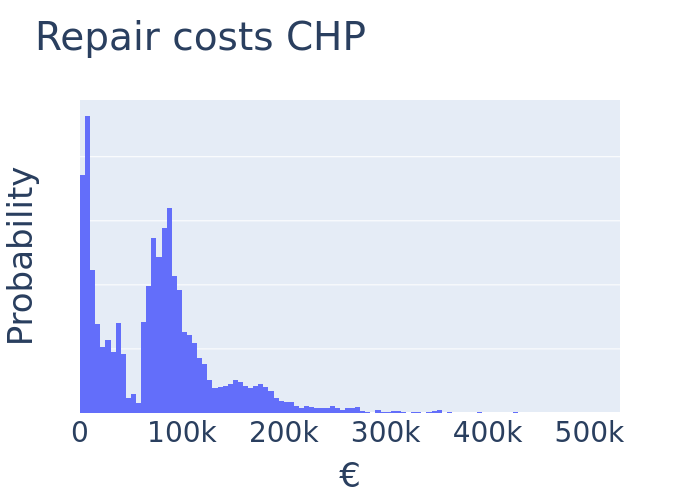

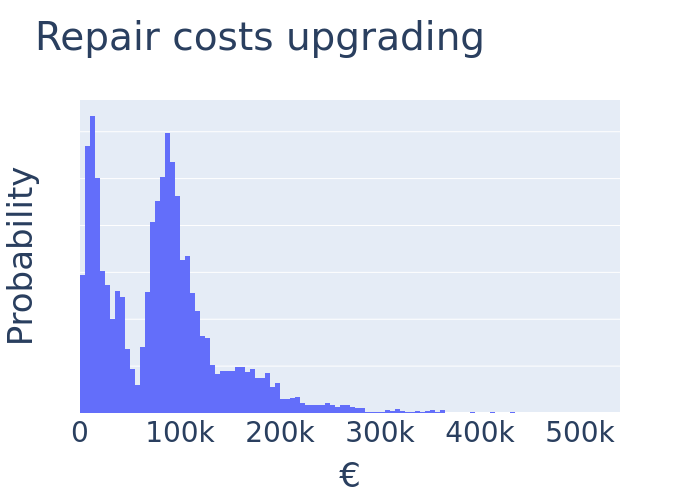

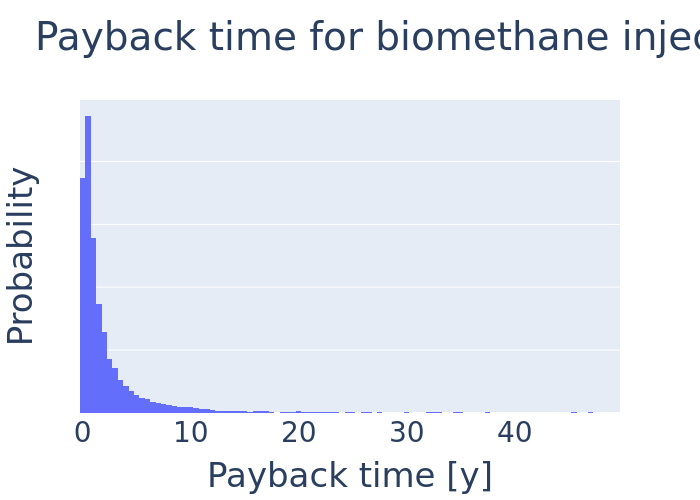

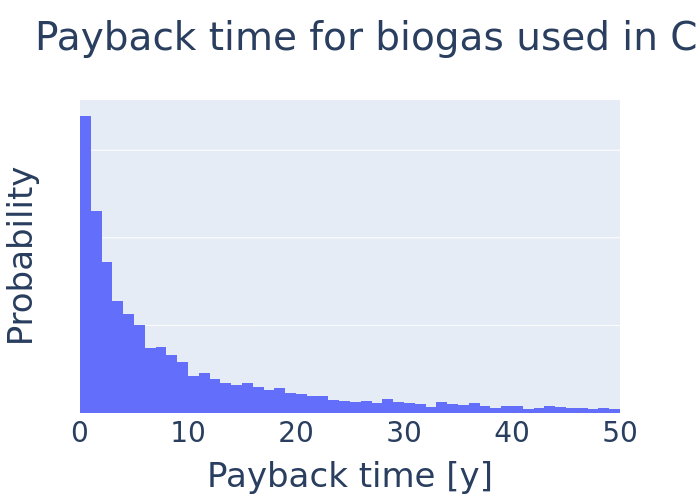

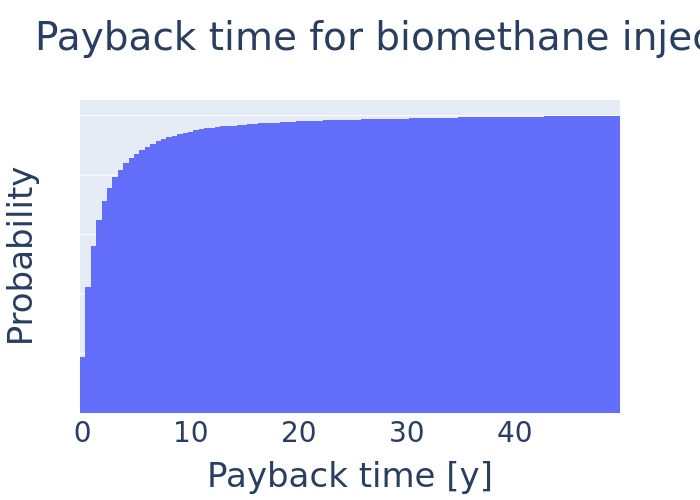

In [32]:
def histo_perc(data, title, x_title, cumulative=False):
    fig = px.histogram(data, histnorm="percent", title=title, cumulative=cumulative)
    fig.layout.update(showlegend=False)
    fig.update_layout(
        xaxis_title=x_title, yaxis_title="Probability", font=dict(size=28)
    )
    fig.update_yaxes(showticklabels=False)
    fig.show(renderer="png")
    fig.write_image(SAVEDIR + title + ".svg")


histo_perc(
    df["leak_number_Digestate storage"], "No. of leaks per plant part", "No. of leaks"
)
histo_perc(df["leak_rate_chp"], "Leak rate CHP", "% of methane produced")
histo_perc(df["leak_rate_upg"], "Leak rate upgrading", "% of methane produced")
histo_perc(df["repair_cost_chp"], "Repair costs CHP", "€")
histo_perc(df["repair_cost_upg"], "Repair costs upgrading", "€")
histo_perc(
    df.query("payback_upg < 50")["payback_upg"],
    "Payback time for biomethane injection",
    "Payback time [y]",
)
histo_perc(
    df.query("payback_chp < 50")["payback_chp"],
    "Payback time for biogas used in CHP",
    "Payback time [y]",
)
histo_perc(
    df.query("payback_upg < 50")["payback_upg"],
    "Payback time for biomethane injection - cumulative",
    "Payback time [y]",
    cumulative=True,
)

## Separate the results for CHP and biomethane upgrading
We want to analyse them seperately to compare their performance

In [33]:
# All this is to create bins with different sizes
bin_size = 10
# The first bins go from 0 to 2, 2 to 5, 5 to 10, and then in steps of 10
bins_upg = np.array(
    [0.0, 2.0, 5.0] + np.arange(10, df["leak_rate_upg"].max() + 1, bin_size).tolist()
)
by_lower_bin = np.digitize(df["leak_rate_upg"], bins_upg[1:], right=True)
upper_bin = np.array(bins_upg[1:].tolist() + [80])
df["leak_bin_upg"] = upper_bin[by_lower_bin].astype(int)
bins_chp = np.array(
    [0.0, 2.0, 5.0] + np.arange(10, df["leak_rate_chp"].max() + 1, bin_size).tolist()
)
by_lower_bin = np.digitize(df["leak_rate_chp"], bins_chp[1:], right=True)
upper_bin = np.array(bins_chp[1:].tolist() + [80])
df["leak_bin_chp"] = upper_bin[by_lower_bin].astype(int)
# combine the CHP and upgrading data as seperate columns in a new dataframe
df_upgrading = df.loc[
    :,
    ["discounted_payback_upg", "payback_upg", "increased_revenue_upg", "leak_bin_upg"],
]
df_upgrading = df_upgrading.rename(
    dict(
        payback_upg="payback",
        leak_bin_upg="leak_bin",
        discounted_payback_upg="discounted_payback",
    ),
    axis=1,
)
df_upgrading.loc[:, "use"] = "upgrading"
df_chp = df.loc[
    :,
    ["discounted_payback_chp", "payback_chp", "increased_revenue_chp", "leak_bin_chp"],
]
df_chp = df_chp.rename(
    dict(
        payback_chp="payback",
        leak_bin_chp="leak_bin",
        discounted_payback_chp="discounted_payback",
    ),
    axis=1,
)
df_chp.loc[:, "use"] = "CHP"
df_expanded = pd.concat([df_upgrading, df_chp], axis=0)

### Table of quantiles for payback time with different leak rate bins

In [34]:
statistics = dict()
for use in df_expanded.use.unique():
    statistics[use] = dict()
    for bin in bins_upg:
        statistics[use, bin] = dict(
            zip(
                ["median", "q3", "95%", "samples"],
                np.append(
                    df_expanded.query(f"use == @use and leak_bin == @bin")["payback"]
                    .quantile([0.5, 0.75, 0.95])
                    .values,
                    len(
                        df_expanded.query(f"use == @use and leak_bin == @bin")[
                            "payback"
                        ]
                    ),
                ),
            )
        )
pd.DataFrame.from_dict(statistics, orient="index").sort_index()

median         q3         95%  samples
CHP       0.0         NaN        NaN         NaN      0.0
          2.0   21.574642  58.196281  267.997861   3802.0
          5.0    5.771411  12.532380   32.093042   3110.0
          10.0   2.618416   5.661978   14.665005   1614.0
          20.0   1.478486   3.055038    7.849348    877.0
          30.0   0.695624   1.558730    3.923561     56.0
upgrading 0.0         NaN        NaN         NaN      0.0
          2.0    3.798238   9.119641   36.149959   2408.0
          5.0    1.169297   2.412612    6.468360   3561.0
          10.0   0.543981   1.174599    3.023228   2242.0
          20.0   0.313502   0.618803    1.564104   1151.0
          30.0   0.146303   0.268474    0.639838     97.0

### Visualisation (violin) of payback time per leakage rate bin

/home/hurtiol/.conda/envs/gnocpy/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



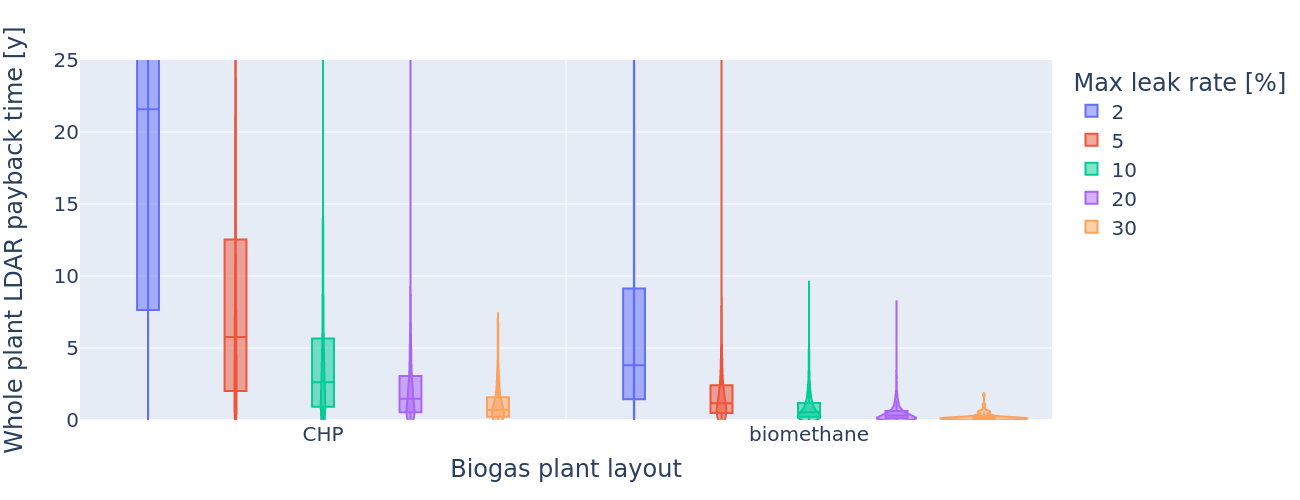

In [35]:
def add_annotations(fig, filter, position, xanchor="left"):
    for x in zip(
        ["median", "75%", "95%"],
        df_expanded.query("use == @filter")["payback"]
        .quantile([0.5, 0.75, 0.95])
        .values,
    ):
        fig.add_annotation(
            xanchor=xanchor,
            x=position,
            y=min(x[1], 24),
            text=x[0] + ": " + format(x[1], ".1f"),
            showarrow=False,
            font=dict(size=12),
        )


def plot_violin_payback(
    df_expanded,
    title,
    x_title,
    y_title,
    color,
    showlegend=False,
    showannotations=True,
    y_to_plot="payback",
):
    df_expanded.replace("upgrading", "biomethane", inplace=True)
    fig = px.violin(
        df_expanded.sort_values(by=[color]),
        y=y_to_plot,
        x="use",
        color=color,
        # title=title,
        box=True,
        points=False,
        hover_data=df_expanded.columns,
        labels={"leak_bin": "Max leak rate [%]"},
    )
    fig.update_layout(
        yaxis_range=[0, 25],
        xaxis_title=x_title,
        yaxis_title=y_title,
        font=dict(size=20),
        showlegend=showlegend,
        width=1300,
        violingap=0.1,
        violingroupgap=0,
        xaxis=dict(
            showgrid=True,
            tickson="boundaries",
        ),
    )
    if showannotations:
        add_annotations(fig, "upgrading", -0.3)
        add_annotations(fig, "CHP", 1.3, "right")
    fig.show(renderer="png")
    fig.write_image(SAVEDIR + title + ".png")


plot_violin_payback(
    df_expanded.query("leak_bin < 40"),
    "LDAR payback time per leak rate",
    "Biogas plant layout",
    "Whole plant LDAR payback time [y]",
    "leak_bin",
    True,
    False,
)

/home/hurtiol/.conda/envs/gnocpy/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



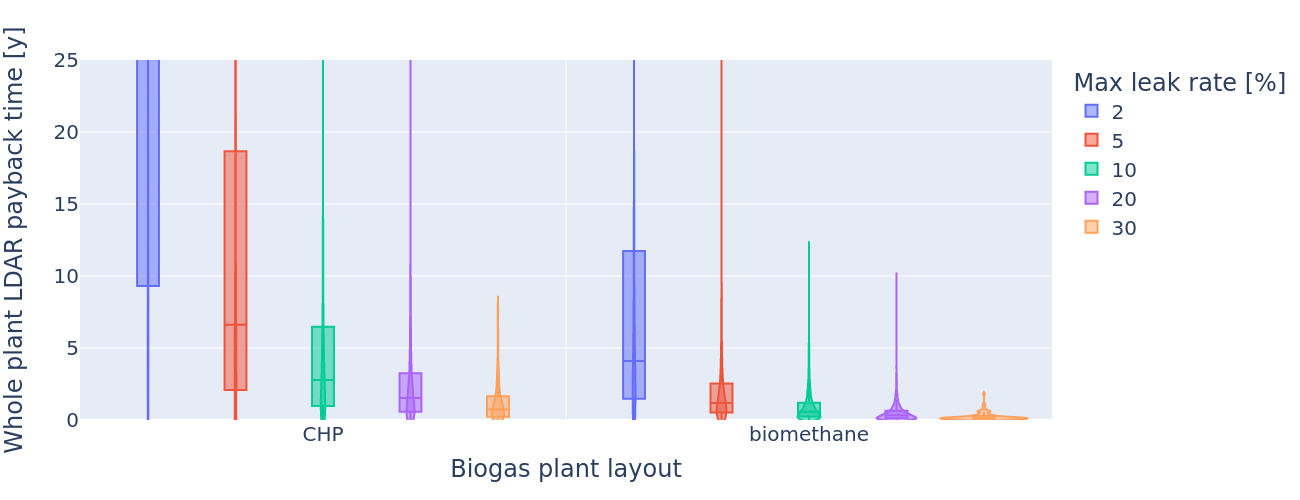

In [36]:
plot_violin_payback(
    df_expanded.query("leak_bin < 40"),
    "LDAR payback time per leak rate - discounted revenues",
    "Biogas plant layout",
    "Whole plant LDAR payback time [y]",
    "leak_bin",
    True,
    False,
    y_to_plot="discounted_payback",
)

### Visualisation (violin) of overall payback time

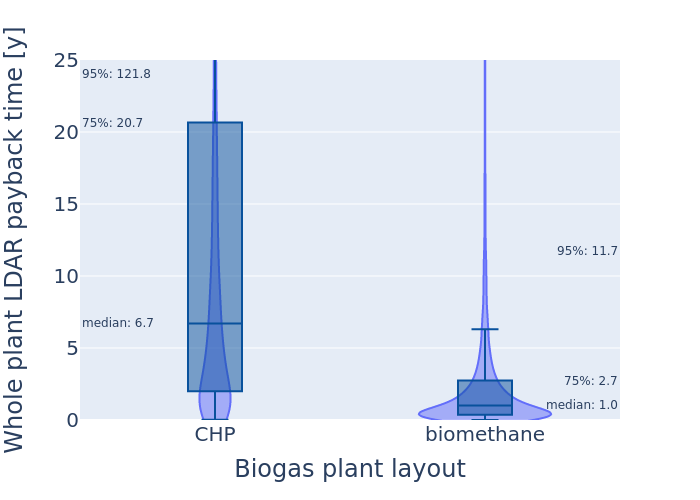

In [37]:
def plot_overall_payback(title="LDAR payback time", y_to_plot="payback"):
    df_expanded.replace("upgrading", "biomethane", inplace=True)
    fig = px.violin(
        df_expanded.query("payback < 40").sort_values(by=["use"]),
        y=y_to_plot,
        x="use",
        # title=title,
        box=False,
        points=False,
        hover_data=df_expanded.columns,
    )
    fig.add_trace(
        go.Box(
            y=df_expanded[y_to_plot],
            x=df_expanded["use"],
            width=0.2,
            # showwhiskers=False,
            boxpoints="outliers",
            line_color="rgb(8,81,156)",
            marker=dict(
                color="rgba(255,255,255,0)",
                outliercolor="rgba(255,255,255,0)",
                line=dict(
                    color="rgba(255,255,255,0)",
                    width=0,
                    outliercolor="rgba(255,255,255,0)",
                    outlierwidth=0,
                ),
            ),
        )
    )
    fig.update_layout(
        yaxis_range=[0, 25],
        xaxis_title="Biogas plant layout",
        yaxis_title="Whole plant LDAR payback time [y]",
        font=dict(size=20),
        showlegend=False,
    )
    add_annotations(fig, "biomethane", 1.5, "right")
    add_annotations(fig, "CHP", -0.5)
    fig.show(renderer="png")
    fig.write_image(SAVEDIR + title + ".png")


plot_overall_payback()

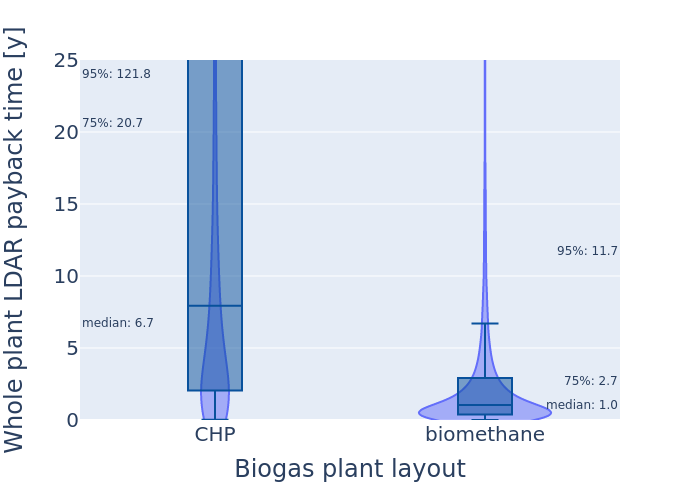

In [38]:
plot_overall_payback("LDAR discounted payback time", "discounted_payback")